### Imports

In [43]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import random_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import MinMaxScaler
import json

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Classes

In [18]:
#Class: RNN
class RNN(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        #h0 = self.initHidden()
        h_list, hn = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

In [19]:
#Class : LSTM
class LSTM(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        h_list, (hn,cn) = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

## Setup

In [20]:
#Parameters to get several scenari
CSV_FILE = "../../data/synthetic_bph_1/Simulations/simulation1.csv"
TRAINING_NUMBER = 400
USE_NOISY_DATA = False
USE_MIXED_EFFECT = True
timestep_skip = 1
MODEL = RNN        

#CONFIG_NAME = "../../models/ODE-RNN/Résultats/"+ str(MODEL) + "_" + "Mixed" + str(USE_MIXED_EFFECT) + "Timestep" + str"timestep_skip.json"

In [21]:
#data loading
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")

In [22]:
x_labels = [
    c for c in data.columns if c.startswith("x") and ((("_" in c) is USE_NOISY_DATA and ('obs' in c) is USE_NOISY_DATA))
]
if 'x8' not in x_labels:
    x_labels.append('x8')
#assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c))
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

print(x_labels)
print(y_labels)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y_mixed_obs']


## Preprocessing

In [23]:
# preprocessing
random.seed(0)
data = data[data['temps']%timestep_skip == 0]
data['y+1'] = data.groupby("individus")[y_labels].shift(-1)
data_norm = data.copy()
data_norm = data_norm.dropna()
N_train = random.sample(range(1,501), TRAINING_NUMBER)
N_train.sort()
N_test =  [x for x in range(1,501) if x not in N_train]
data_train = data_norm.loc[data_norm['individus'].isin(N_train)]
data_test = data_norm[~data_norm['individus'].isin(N_train)]

scaler_x = MinMaxScaler()
data_train.loc[:,x_labels + y_labels] = scaler_x.fit_transform(data_train[x_labels + y_labels])
data_test.loc[:,x_labels + y_labels] = scaler_x.transform(data_test[x_labels + y_labels ])

scaler_y = MinMaxScaler()
data_train.loc[:,['y+1']] = scaler_y.fit_transform(data_train[['y+1']])
data_test.loc[:,['y+1']] = scaler_y.transform(data_test[['y+1']])

groupby = data_train.groupby('individus')[x_labels + y_labels].apply(np.array)
input_train = [torch.Tensor(x) for x in groupby]
input_train = torch.stack(input_train)
groupby = data_train.groupby('individus')[['y+1']].apply(np.array)
target_train = [torch.Tensor(x) for x in groupby]
target_train = torch.stack(target_train)

groupby = data_test.groupby('individus')[x_labels + y_labels].apply(np.array)
input_test = [torch.Tensor(x) for x in groupby]
input_test = torch.stack(input_test)
groupby = data_test.groupby('individus')[['y+1']].apply(np.array)
target_test = [torch.Tensor(x) for x in groupby]
target_test = torch.stack(target_test)
#seq_lens = [len(inp) for inp in groupby]
#input_padded = pad_sequence([torch.tensor(x) for x in groupby])
#input_pack_padded = pack_padded_sequence(input_padded, lengths=seq_lens)



## Training

In [26]:
#hyperparamètres
hidden_size = [25]
learning_rate = [ 0.001]
criterion = torch.nn.L1Loss()
epoch = 1000
eps = 0.001

In [27]:
#Training with convergence criteria and GridSearch
min_loss = float('inf')
for h in hidden_size:
    for lr in learning_rate:
        model = MODEL(input_size = 9, hidden_size=h, output_size=1)
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        loss_val = [float('inf')]*100
        loss_train = []
        cur_loss_val = 0
        nb_epochs = 0
        while abs(np.max(loss_val[-100:] - np.min(loss_val[-100:] + [cur_loss_val]))) >= eps:

            y_test = model(input = input_test)
            cur_loss_val = criterion(y_test, target_test).item()
            loss_val.append(cur_loss_val)

            optimizer.zero_grad()
            y_pred = model(input=input_train)
            loss = criterion(y_pred, target_train)
            loss.backward()
            optimizer.step()

            cur_loss_train = loss.item()
            loss_train.append(cur_loss_train)
            
            nb_epochs += 1
        if cur_loss_val < min_loss:
            min_loss = cur_loss_val
            res = (h, lr)

loss_val = loss_val[101:]
print(h, lr)
print(nb_epochs)

25 0.001
436


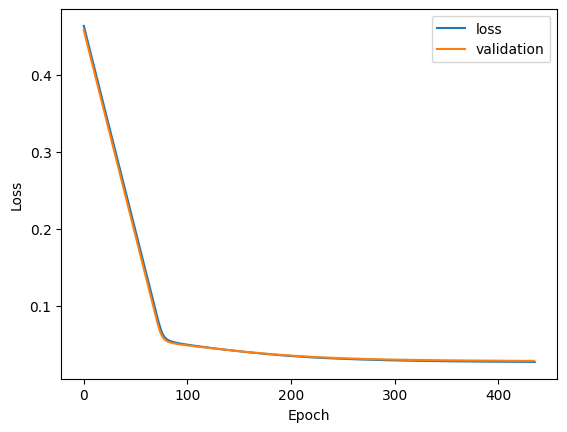

In [28]:
#plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(loss_track)
plt.plot(loss_train, label ="loss")
plt.plot(loss_val, label = "validation")
plt.legend()
plt.show()

In [29]:
#unscale data
multi_index = pd.MultiIndex.from_product([N_train, range(y_pred.shape[1])], names=['individus', 'temps'])
df = pd.DataFrame(index = multi_index, data = y_pred.detach().numpy().flatten(), columns=['y_pred'])
df = df.reset_index()
df = df.set_index(data_train.index)
df.loc[:,'y_pred'] = scaler_y.inverse_transform(df[['y_pred']])
data_train.loc[:,['y+1']] = scaler_y.inverse_transform(data_train[['y+1']])

In [30]:
#Results on training
MAE_list_train = []
for k in N_train:
    pred_k = df[(df['temps']!=0) & (df['individus'] == k)]['y_pred']
    target_k = data_train[(data_train['temps']!=0) & (data_train['individus'] == k)]['y+1']
    MAE_list_train.append(MAE(pred_k, target_k))
print("mean MAE on train data: ", np.mean(MAE_list_train))

mean MAE on train data:  16.55000584608526


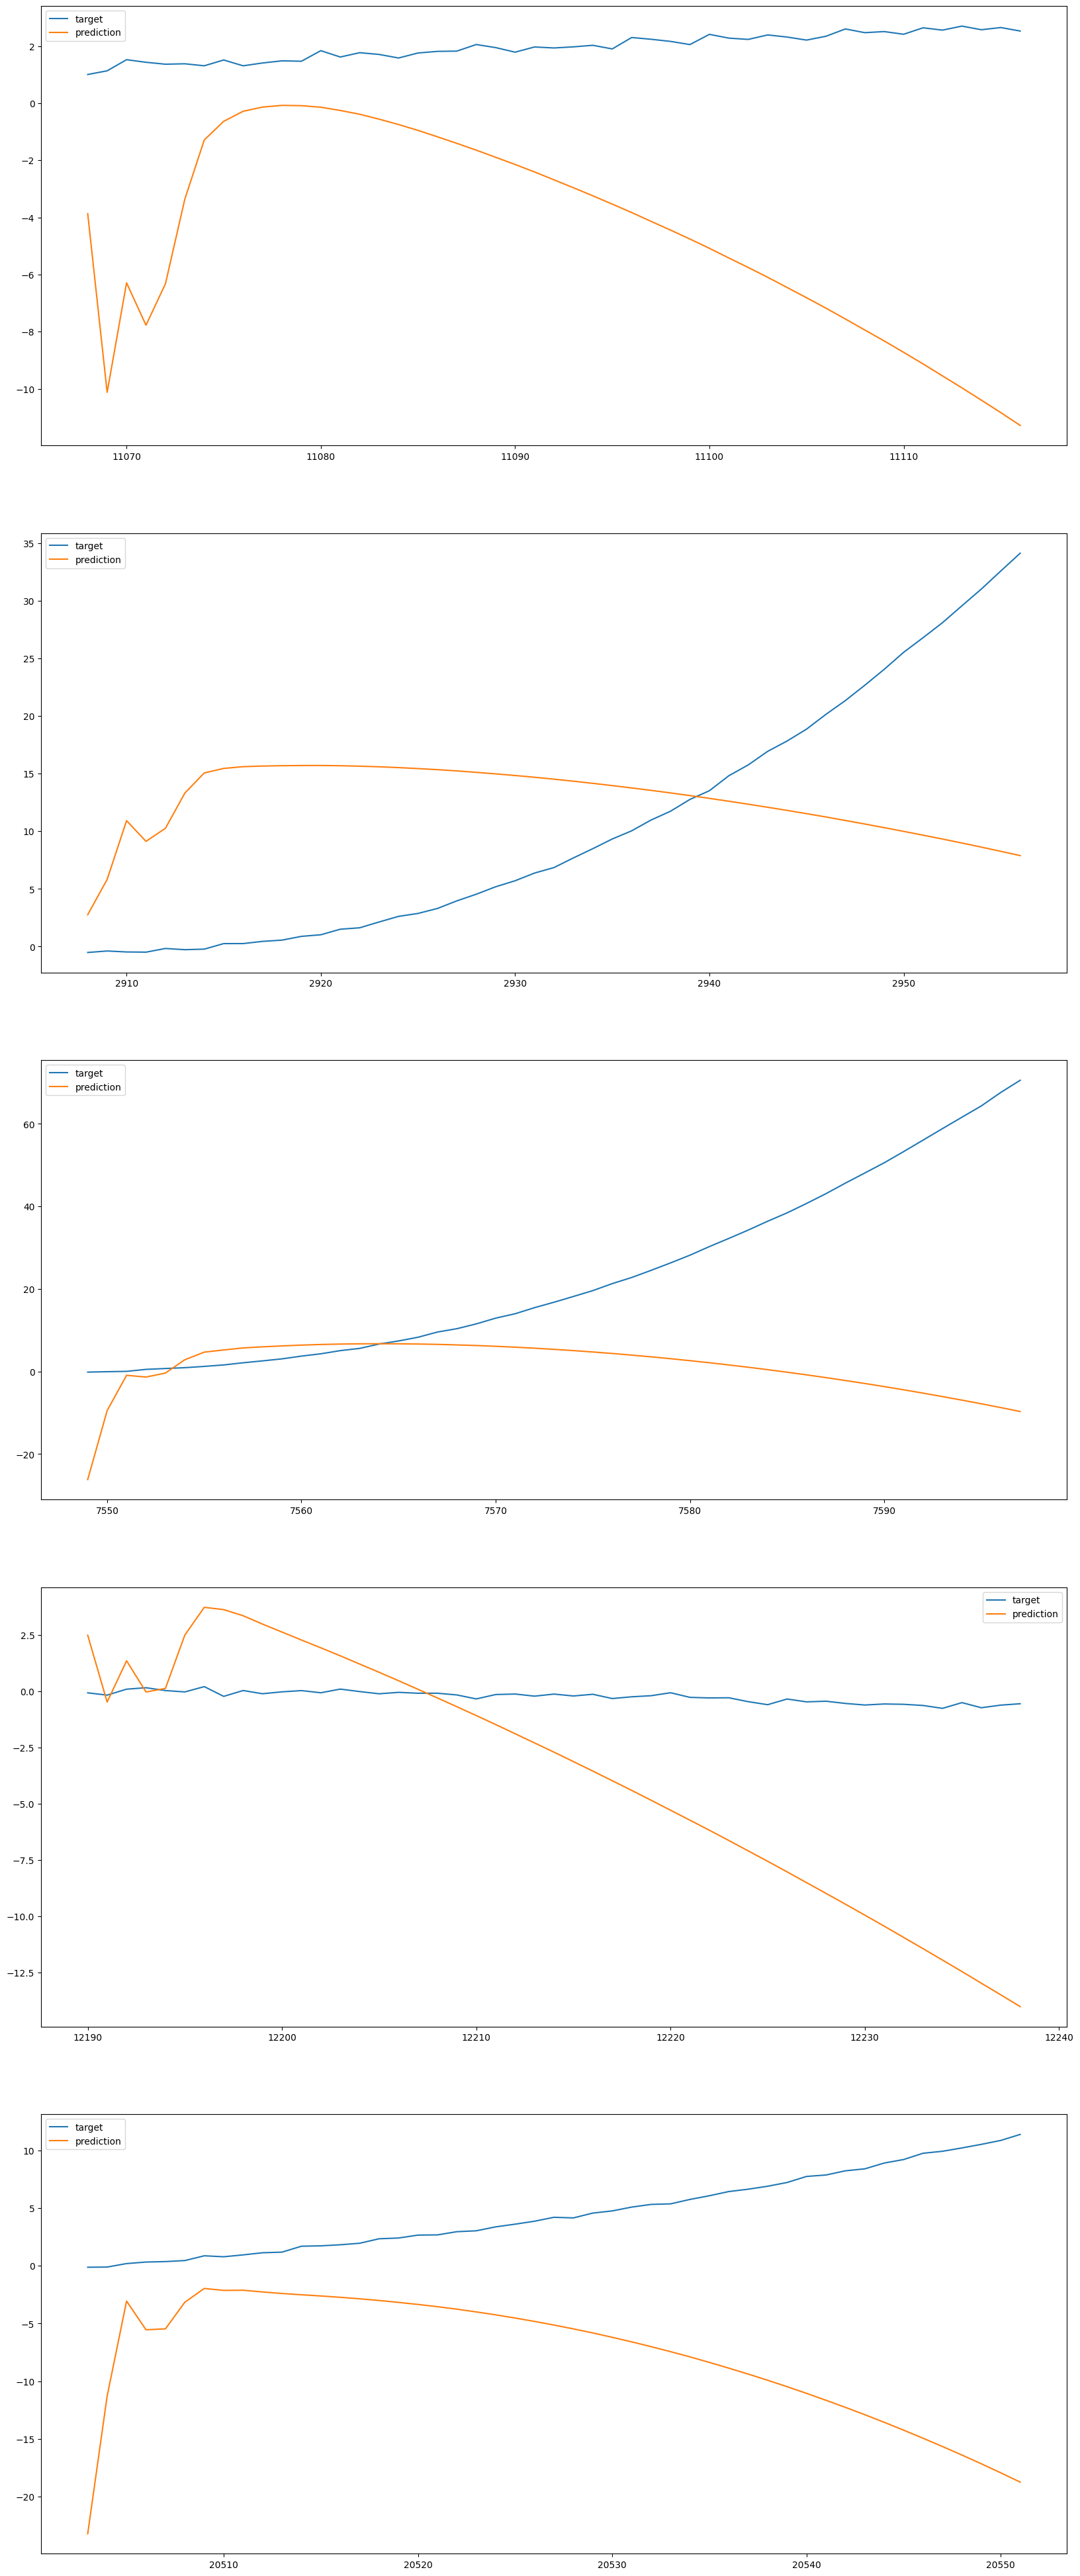

In [31]:
#Plot 4 random curves from training data and worst individual
n = 5
ex = np.random.choice(N_train, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(data_train.loc[(data_train['temps']!=0) & (data_train['individus']== ex[k])]['y+1'], label= 'target')
    axs[k].plot(df.loc[(df['temps']!=0) & (df['individus']==ex[k])]['y_pred'], label= 'prediction')
    axs[k].legend()

## Test

In [32]:
y_test = model(input_test)
multi_index_test = pd.MultiIndex.from_product([N_test, range(y_test.shape[1])], names=['individus', 'temps'])
df_test = pd.DataFrame(index = multi_index_test, data = y_test.detach().numpy().flatten(), columns=['y_test'])
df_test = df_test.reset_index()
df_test = df_test.set_index(data_test.index)
df_test.loc[:,'y_test'] = scaler_y.inverse_transform(df_test[['y_test']])
data_test.loc[:,'y+1'] = scaler_y.inverse_transform(data_test[['y+1']])

In [33]:
#MAE on test data
MAE_list_test = []
for k in N_test:
    pred_k = df_test[(df_test['temps']!=0) & (df_test['individus'] == k)]['y_test']
    target_k = data_test[(data_test['temps']!=0) & (data_test['individus'] == k)]['y+1']
    MAE_list_test.append(MAE(pred_k,target_k))
print("mean MAE on test data: ", np.mean(MAE_list_test))

mean MAE on test data:  17.46911871950792


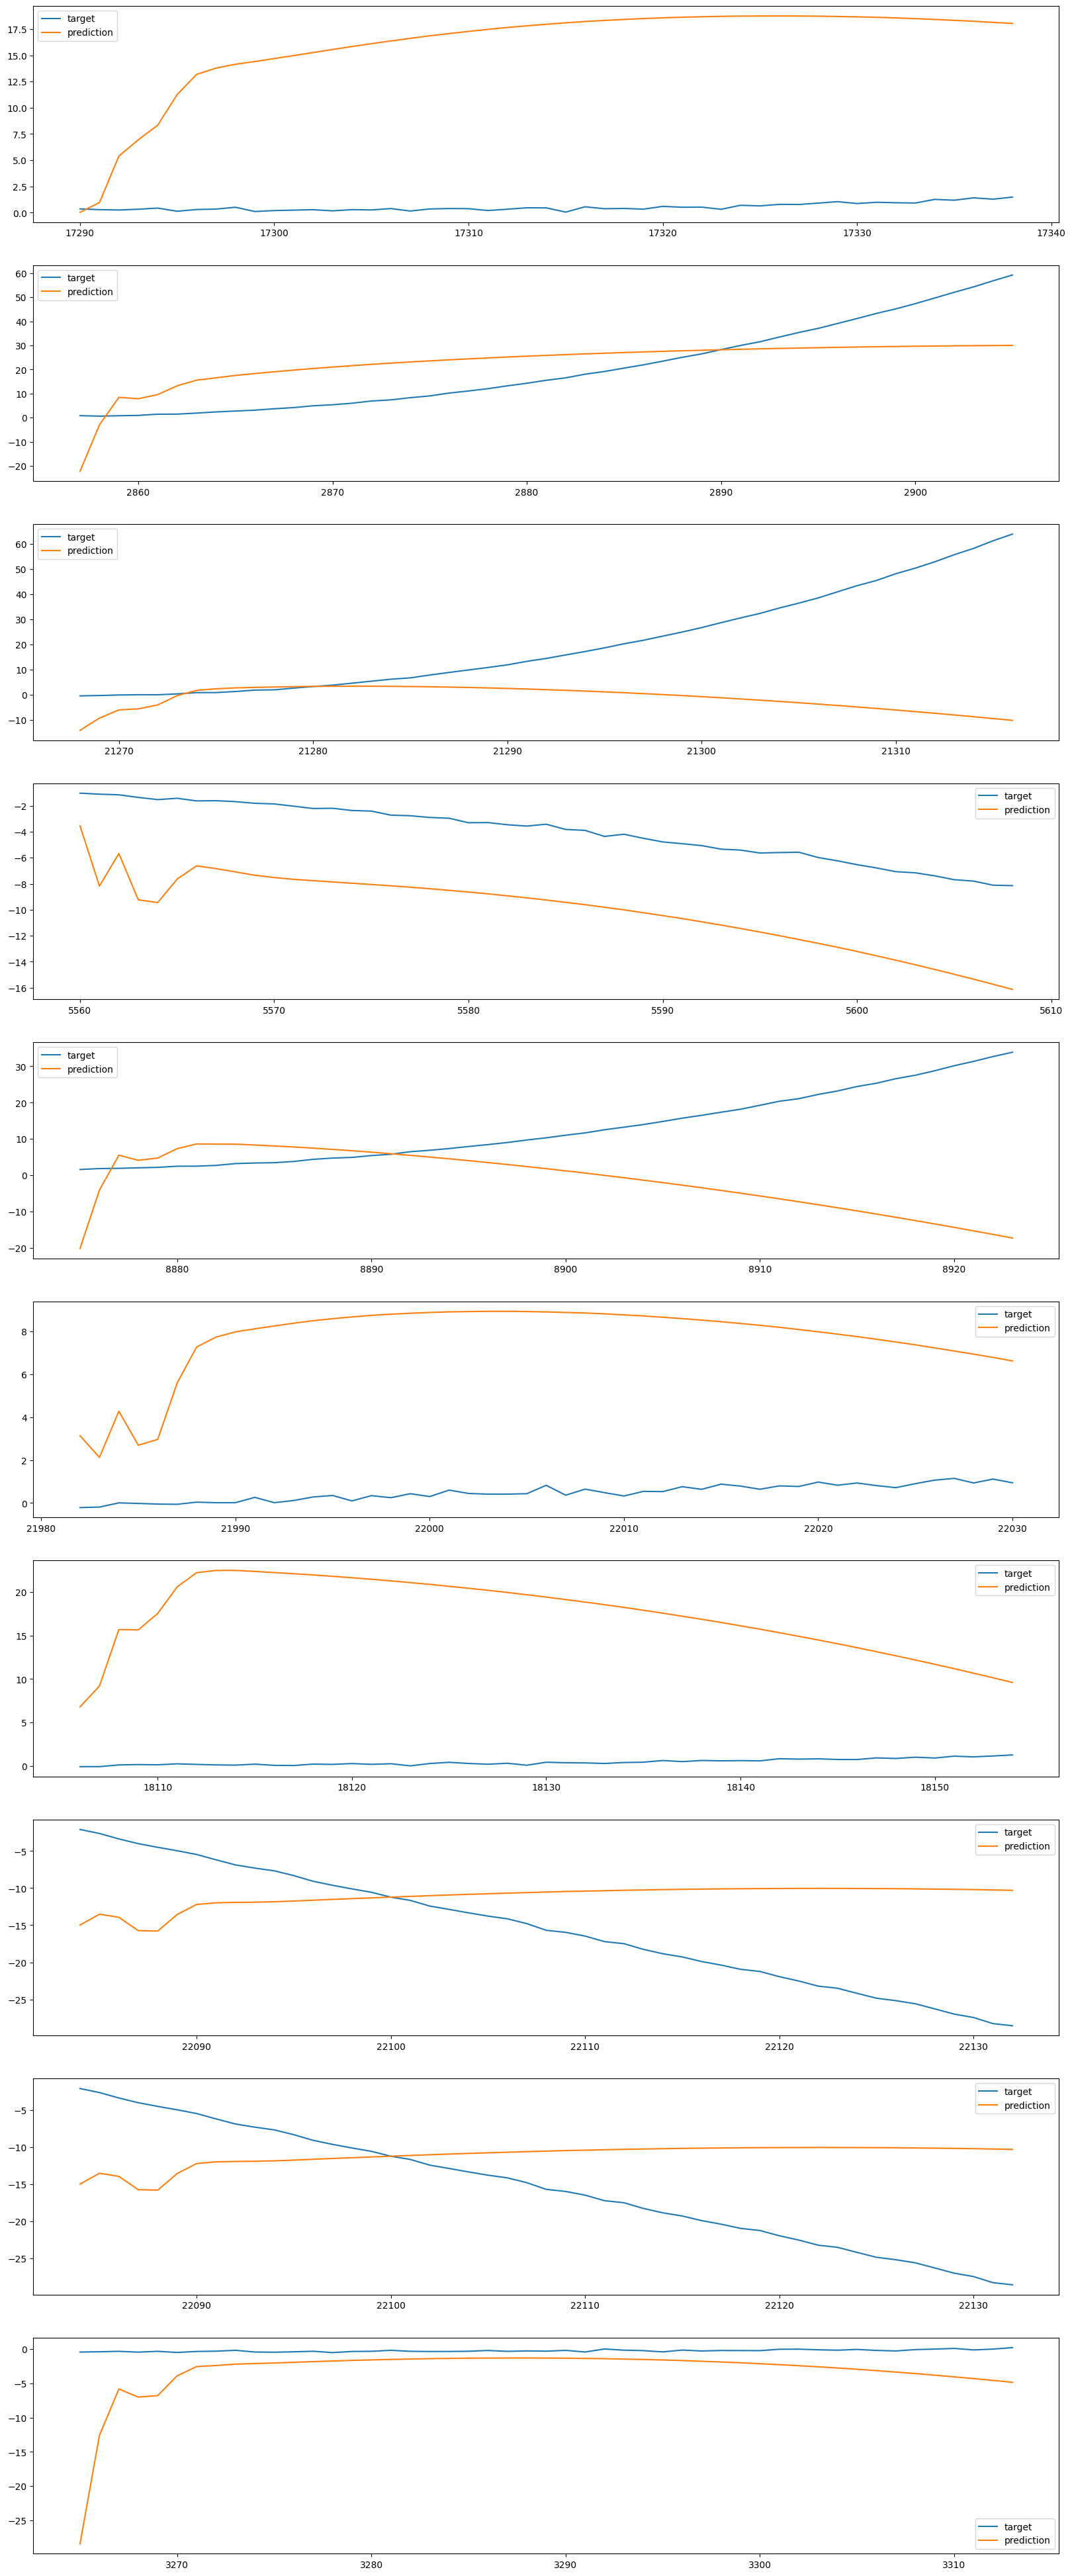

In [34]:
n = 10
ex = np.random.choice(N_test, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(data_test.loc[(data_test['temps']!=0) & (data_test['individus']==ex[k])]['y+1'], label= 'target')
    axs[k].plot(df_test.loc[(df_test['temps']!=0) & (df_test['individus']==ex[k])]['y_test'], label= 'prediction')
    axs[k].legend()

## Saving results

In [49]:
results = pd.DataFrame([[USE_MIXED_EFFECT, MODEL, nb_epochs, np.mean(MAE_list_train), np.mean(MAE_list_test)]], 
                       columns=['Random effect', 'Model', 'nb_epochs', "MAE moyenne sur l'entrainement", "MAE moyenne sur le test"])
results = results.to_json(path_or_buf="../../models/ODE-RNN/Résultats/"+ MODEL.__name__ + "_" + "Mixed" + str(USE_MIXED_EFFECT) + "Timestep" + str("timestep_skip.json"))